In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import glob
import os
from os.path import expanduser
import re

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 
sns.set();

In [3]:
home = expanduser("~")
path2data = home + '/.kaggle/competitions/recruit-restaurant-visitor-forecasting/'

In [4]:
# folder to save figures
path2figures = 'figures/'
if  not os.path.exists(path2figures): os.mkdir(path2figures)

## Download Dataset

In [5]:
if  not os.path.exists(path2data):
    !pip install kaggle
    !kaggle competitions download -c recruit-restaurant-visitor-forecasting -p ~/.kaggle/competitions/recruit-restaurant-visitor-forecasting
    !cd ~/.kaggle/competitions/recruit-restaurant-visitor-forecasting && ls && unzip "*.zip"
else:
    print('Dataset already downloaded!')

Dataset already downloaded!


In [6]:
files = glob.glob(path2data + '*.csv')
files

['/home/renatolr/.kaggle/competitions/recruit-restaurant-visitor-forecasting/date_info.csv',
 '/home/renatolr/.kaggle/competitions/recruit-restaurant-visitor-forecasting/sample_submission.csv',
 '/home/renatolr/.kaggle/competitions/recruit-restaurant-visitor-forecasting/air_store_info.csv',
 '/home/renatolr/.kaggle/competitions/recruit-restaurant-visitor-forecasting/air_reserve.csv',
 '/home/renatolr/.kaggle/competitions/recruit-restaurant-visitor-forecasting/hpg_store_info.csv',
 '/home/renatolr/.kaggle/competitions/recruit-restaurant-visitor-forecasting/air_visit_data.csv',
 '/home/renatolr/.kaggle/competitions/recruit-restaurant-visitor-forecasting/store_id_relation.csv',
 '/home/renatolr/.kaggle/competitions/recruit-restaurant-visitor-forecasting/hpg_reserve.csv']

## Data Loading

In [7]:
dfs = { re.search('/([^/\.]*)\.csv', fn).group(1):
    pd.read_csv(fn)for fn in glob.glob( path2data +'*.csv')}
for k, v in dfs.items(): locals()[k] = v

- **air_store_info** contains information about select air restaurants.

- **air_visit_data** contains historical visit data for the air restaurants. It has basicaly the id of the reservation using the air system, visit_date and the number of visitors. In order to combine the provided informations with the new feature we have created a new structure **visitors**. 

- **hpg_store_info** contains information about select hpg restaurants.

- **hpg_reserve** contains informations abourt reservation made using hpg. 

- **air_reserve** contains informations abourt reservation made using air. 

In [8]:
for k,v in  dfs.items(): print(k)

date_info
sample_submission
air_store_info
air_reserve
hpg_store_info
air_visit_data
store_id_relation
hpg_reserve


### Get train and test data

In [9]:
sample_submission['air_store_id'] = sample_submission.id.map(lambda x: '_'.join(x.split('_')[:-1]))
sample_submission['visit_date'] = sample_submission.id.map(lambda x: x.split('_')[2])
sample_submission = sample_submission.drop('id', axis='columns')
sample_submission['visitors'] = np.nan
sample_submission['test_set'] = True

In [10]:
sample_submission.head(3)

,visitors,air_store_id,visit_date,test_set
0,NaN,air_00a91d42b08b08d9,2017-04-23,True
1,NaN,air_00a91d42b08b08d9,2017-04-24,True
2,NaN,air_00a91d42b08b08d9,2017-04-25,True


In [11]:
air_visit_data =  pd.concat((air_visit_data, sample_submission))

In [12]:
air_visit_data.head()

,air_store_id,test_set,visit_date,visitors
0,air_ba937bf13d40fb24,NaN,2016-01-13,25.0
1,air_ba937bf13d40fb24,NaN,2016-01-14,32.0
2,air_ba937bf13d40fb24,NaN,2016-01-15,29.0
3,air_ba937bf13d40fb24,NaN,2016-01-16,22.0
4,air_ba937bf13d40fb24,NaN,2016-01-18,6.0


In [13]:
air_visit_data.shape

(284127, 4)

### Inner join between the two data sources (air and hpg)

**store_id_relation** has the relationship between the two separate sites in which the data comes:
    
Hot Pepper Gourmet (**hpg**): similar to Yelp, here users can search restaurants and also make a reservation online

AirREGI / Restaurant Board (**air**): similar to Square, a reservation control and cash register system

In [14]:
store_id_relation.head()

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


In [15]:
air_info = air_reserve.merge(air_store_info, on='air_store_id', how='left', suffixes=('', '_y'))

In [16]:
data = air_visit_data.merge(air_store_info, on='air_store_id', how='left', suffixes=('', '_y'))
data = data.merge(store_id_relation, on='air_store_id', how='left', suffixes=('', '_y')) 
data = data.merge(hpg_store_info, on='hpg_store_id', how='left', suffixes=('', '_y'))

In [17]:
data.head(2)

,air_store_id,test_set,visit_date,visitors,air_genre_name,air_area_name,latitude,longitude,hpg_store_id,hpg_genre_name,hpg_area_name,latitude_y,longitude_y
0,air_ba937bf13d40fb24,NaN,2016-01-13,25.0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN
1,air_ba937bf13d40fb24,NaN,2016-01-14,32.0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN


**Date info** carry out information about the calendary. Has proposed by [zeemeen](https://www.kaggle.com/zeemeen/weighted-mean-comparisons-lb-0-497-1st) we have created a new feature **Weight** which creates a podenration factor around the days that are holidays.

In [18]:
wkend_holidays = date_info.apply(lambda x: (x.day_of_week=='Sunday' or x.day_of_week=='Saturday') and x.holiday_flg==1, axis=1)
wkend_holidays.value_counts()

date_info.loc[wkend_holidays, 'holiday_flg'] = 0
date_info['weight'] = ((date_info.index + 1) / len(date_info)) ** 5

In [19]:
date_info.head(5)

,calendar_date,day_of_week,holiday_flg,weight
0,2016-01-01,Friday,1,2.707368e-14
1,2016-01-02,Saturday,0,8.663577e-13
2,2016-01-03,Sunday,0,6.578904e-12
3,2016-01-04,Monday,0,2.772345e-11
4,2016-01-05,Tuesday,0,8.460525e-11


In [20]:
data = data.merge(date_info, left_on='visit_date', right_on='calendar_date', how='left')
data['visitors_log'] = data.visitors.map(pd.np.log1p)

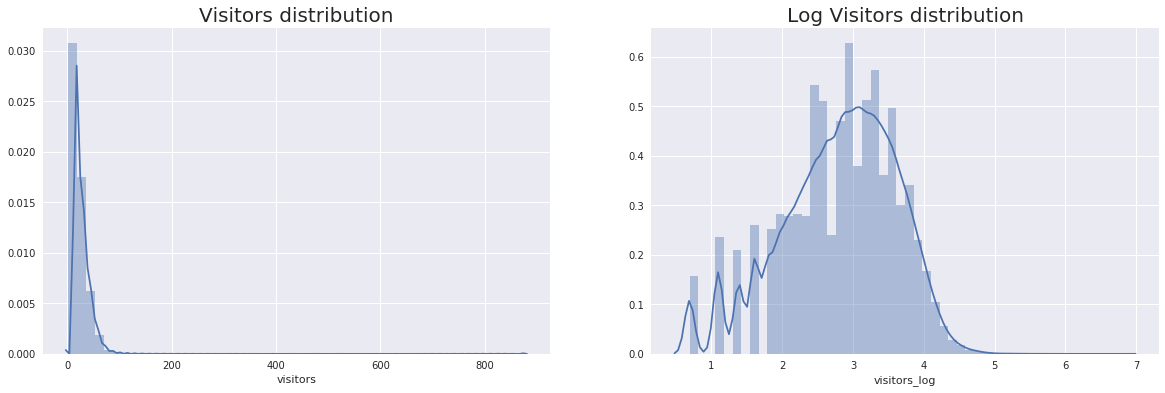

In [21]:
fig = plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
sns.distplot(data[data['visitors'].notnull()]['visitors'])
plt.title('Visitors distribution', fontsize=20)
plt.subplot(1,2,2)
sns.distplot(data[data['visitors'].notnull()]['visitors_log'])
plt.title('Log Visitors distribution', fontsize=20)

fig.savefig(path2figures + 'visitor_distribution.png')

In [22]:
data.head(2)

,air_store_id,test_set,visit_date,visitors,air_genre_name,air_area_name,latitude,longitude,hpg_store_id,hpg_genre_name,hpg_area_name,latitude_y,longitude_y,calendar_date,day_of_week,holiday_flg,weight,visitors_log
0,air_ba937bf13d40fb24,NaN,2016-01-13,25.0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,2016-01-13,Wednesday,0,1.005227e-08,3.258097
1,air_ba937bf13d40fb24,NaN,2016-01-14,32.0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,2016-01-14,Thursday,0,1.456087e-08,3.496508


In [23]:
data[data['visitors'].notnull()][['visitors', 'visitors_log']].describe()

,visitors,visitors_log
count,252108.000000,252108.000000
mean,20.973761,2.802788
std,16.757007,0.807726
min,1.000000,0.693147
25%,9.000000,2.302585
50%,17.000000,2.890372
75%,29.000000,3.401197
max,877.000000,6.777647


### Weather informations

In order to create a more robust model, we have used information about the [weather](https://www.kaggle.com/huntermcgushion/rrv-weather-data). The cell bellow will download automatically this dataset. To add the precipitation and avg_temperature it will be used the function [add_weather](https://gist.github.com/superMDguy/72689a11746079677ddb0d19f26443a1) as demonstrated bellow.

In [24]:
path2weather = 'raw/weather/'

In [25]:
if  not os.path.exists(path2weather):
    !wget -O rrv-weather-data.zip "https://storage.googleapis.com/kaggle-datasets/7480/12096/rrv-weather-data.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1528816610&Signature=kDnX2dX3Pd8VGbR6rqRmDH7XYFjBiKYnz3hoez3AWjv0oUf2vJKLpYKV7zfLb%2FgNJE2kXy9D8%2BNvmNkx4LrJHRvVrIMsGyMe%2FM0x1Z3Kxk6nJMSI9BDZGhsyBSONBKPNdND%2FEHuo2k1T2Wo8tOBu1VOOQlLt8NkblTCBx3ihEvEapCq6UgtfNvYvnE55MI8TBCNLcMBBBUU3Cv251yywybyUTAGRfWfIoc2hcYkrVV0j8EtOCfX5CKrAmvxhnuzLBKvlapIrYmOLRtwjlyFfQh2nWqpQGb7ORj%2BUfTvL3trMgOd06aozbCj4A207p%2FBd2IBEweYElxsgddGdpwaLHg%3D%3D"
    !mkdir -p raw/weather/
    !mv rrv-weather-data.zip raw/weather/
    !cd raw/weather/ && unzip rrv-weather-data.zip
else:
    print('Weather Dataset already downloaded!')

Weather Dataset already downloaded!


In [26]:
# This is an example of the used weather file
pd.read_csv(path2weather + '1-1-16_5-31-17_Weather/tokyo__tokyo-kana__tonokyo.csv').head()

,calendar_date,avg_temperature,high_temperature,low_temperature,precipitation,hours_sunlight,solar_radiation,deepest_snowfall,total_snowfall,avg_wind_speed,avg_vapor_pressure,avg_local_pressure,avg_humidity,avg_sea_pressure,cloud_cover
0,2016-01-01,7.5,12.1,3.6,NaN,9.0,11.80,NaN,NaN,2.6,4.5,1022.4,45.0,1025.4,2.5
1,2016-01-02,7.3,13.4,2.6,NaN,7.5,11.59,NaN,NaN,1.9,5.2,1018.6,51.0,1021.5,4.3
2,2016-01-03,9.3,16.2,3.0,NaN,8.3,10.77,NaN,NaN,1.4,7.0,1013.2,61.0,1016.2,5.3
3,2016-01-04,9.2,15.2,4.4,NaN,8.9,11.19,NaN,NaN,1.6,6.8,1010.4,60.0,1013.3,0.0
4,2016-01-05,10.9,15.4,5.1,NaN,8.4,10.57,NaN,NaN,1.8,6.5,1013.1,51.0,1016.0,2.8


In [27]:
def add_weather(dataset, path2weather='raw/weather/'):                                                                                                                     
    print('Adding weather...')                                                                                                                
    air_nearest = pd.read_csv(                                                                                                                
        path2weather + 'air_store_info_with_nearest_active_station.csv')                                                              
    unique_air_store_ids = list(dataset.air_store_id.unique())                                                                                
                                                                                                                                              
    weather_dir = path2weather + '1-1-16_5-31-17_Weather/'                                                                            
    weather_keep_columns = ['precipitation', 'avg_temperature']                                                                                                                         
                                                                                                                                              
    dataset_with_weather = dataset.copy()                                                                                                     
    for column in weather_keep_columns:                                                                                                       
        dataset_with_weather[column] = np.nan
        
    for air_id in unique_air_store_ids:                                                                                                       
        station = air_nearest[air_nearest.air_store_id == air_id].station_id.iloc[0]  
        weather_data = pd.read_csv(weather_dir + station + '.csv', parse_dates=['calendar_date']).rename(columns={'calendar_date': 'visit_date'})                                                                                                                                               
        
        #change datetime format
        weather_data['visit_date'] = weather_data['visit_date'].dt.strftime('%Y-%m-%d')
        this_store = dataset.air_store_id == air_id                                                                                           
        merged = dataset[this_store].merge(weather_data, on='visit_date', how='left')                                                         
        for column in weather_keep_columns:                                                                                                   
            dataset_with_weather.loc[this_store, column] = merged[column]           
    
    return dataset_with_weather    

In [28]:
air_store_info_with_active_station = pd.read_csv(path2weather + 'air_store_info_with_nearest_active_station.csv')

In [29]:
air_store_info_with_active_station.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude,latitude_str,longitude_str,station_id,station_latitude,station_longitude,station_vincenty,station_great_circle
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,"""34.6951242""","""135.1978525""",hyogo__kobe-kana__koube,34.696667,135.211667,1.277232,1.274882
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,"""34.6951242""","""135.1978525""",hyogo__kobe-kana__koube,34.696667,135.211667,1.277232,1.274882
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,"""34.6951242""","""135.1978525""",hyogo__kobe-kana__koube,34.696667,135.211667,1.277232,1.274882
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,"""34.6951242""","""135.1978525""",hyogo__kobe-kana__koube,34.696667,135.211667,1.277232,1.274882
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,"""35.6580681""","""139.7515992""",tokyo__tokyo-kana__tonokyo,35.691667,139.750000,3.730672,3.739835


In [30]:
data = pd.merge(left=data, right=air_store_info_with_active_station, on='air_store_id', how='left', suffixes=('', '_y'))

In [31]:
data = add_weather(data)

Adding weather...


In [32]:
# Handle missing data
# We could replace this block by the avg_temperature and precipitation of stations which are closer

data['precipitation'].fillna(data.precipitation.mean(), inplace=True)
data['avg_temperature'].fillna(data.avg_temperature.mean(), inplace=True)

In [33]:
def drop_y(df):
    # list comprehension of the cols that end with '_y'
    to_drop = [x for x in df if x.endswith('_y')]
    df.drop(to_drop, axis=1, inplace=True)
    return df

In [34]:
data = drop_y(data)

### Extract informations about the spatial location of the restaurant
    - Todofuken
    - city
    - street

In [35]:
area  = data.air_area_name.str.split(' ', expand=True)

data['Todofuken'] = area[0]
data['city'] = area[1]
data['street'] = area.iloc[:, 2:].apply(lambda row: ' '.join(row.dropna()), axis=1)

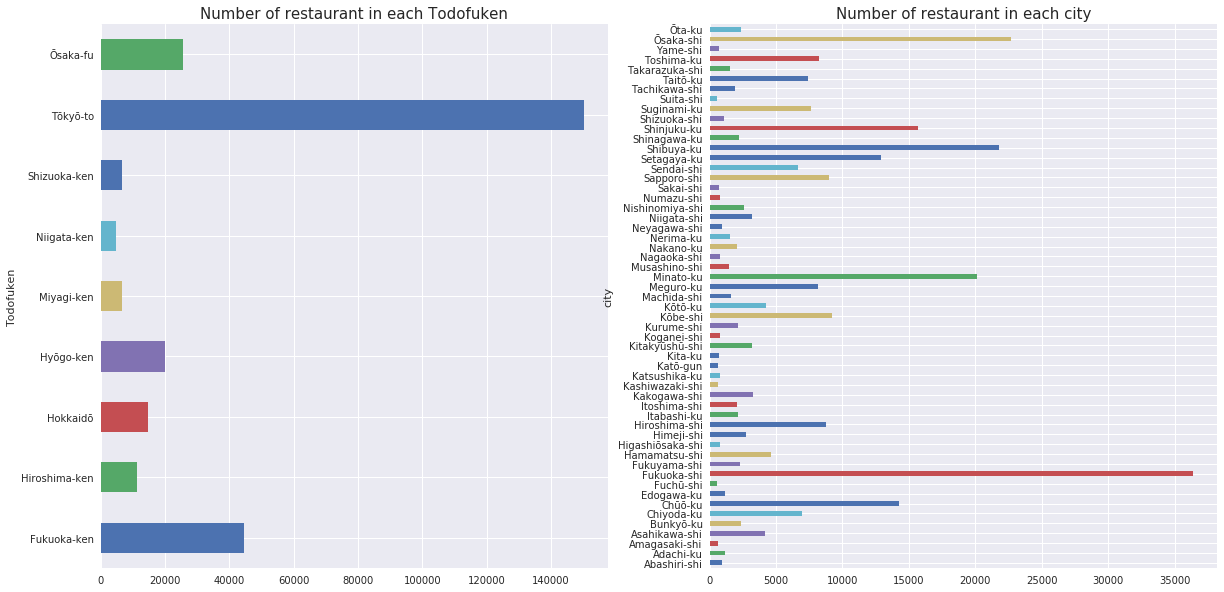

In [36]:
fig = plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
data.groupby(['Todofuken']).size().plot(kind = 'barh')
plt.title('Number of restaurant in each Todofuken', fontsize=15)

plt.subplot(1,2,2)
data.groupby(['city']).size().plot(kind = 'barh')
plt.title('Number of restaurant in each city', fontsize=15)
          
fig.savefig(path2figures + 'stores_distribution.png')

### Obtain informations about reservations

In [37]:
air_reserve['visit_datetime'] = air_reserve.visit_datetime.astype('datetime64[ns]')
air_reserve['reserve_ahead'] = air_reserve.visit_datetime.astype('datetime64[ns]') - air_reserve.reserve_datetime.astype('datetime64[ns]')
air_reserve['reserve_ahead_seconds'] = air_reserve['reserve_ahead'].apply(lambda x: x.seconds)

In [38]:
air_reserve.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,reserve_ahead,reserve_ahead_seconds
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,03:00:00,10800
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,00:00:00,0
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,00:00:00,0
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,04:00:00,14400
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5,19:00:00,68400


In [39]:
data  =  pd.merge(left=data,  right=air_reserve, how='left', 
                left_on=['air_store_id', 'visit_date'], 
                right_on=['air_store_id', 'visit_datetime'])

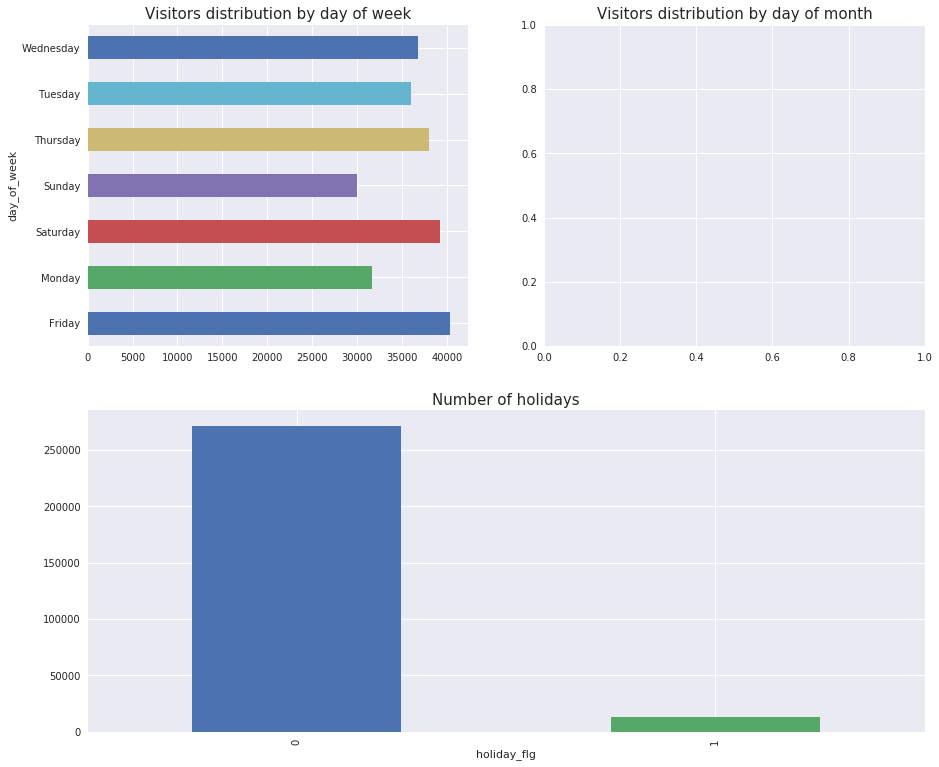

In [40]:
fig = plt.figure(figsize=(15,13))
plt.subplot(2,2,1)
plt.title('Visitors distribution by day of week', fontsize=15)
data.groupby('day_of_week')['visitors'].count().plot(kind = 'barh')

plt.subplot(2,2,2)
plt.title('Visitors distribution by day of month', fontsize=15)

plt.subplot(2,2,(3,4))
plt.title('Number of holidays', fontsize=15)
data.groupby('holiday_flg').size().plot(kind = 'bar')

fig.savefig(path2figures + 'visitor_distribution_period.png')

In [41]:
print('Dataset shape: {}'.format(data.shape))

Dataset shape: (284127, 33)


In [42]:
data.head()

,air_store_id,test_set,visit_date,visitors,air_genre_name,air_area_name,latitude,longitude,hpg_store_id,hpg_genre_name,...,precipitation,avg_temperature,Todofuken,city,street,visit_datetime,reserve_datetime,reserve_visitors,reserve_ahead,reserve_ahead_seconds
0,air_ba937bf13d40fb24,NaN,2016-01-13,25.0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,...,NaN,4.3,Tōkyō-to,Minato-ku,Shibakōen,NaT,NaN,NaN,NaT,NaN
1,air_ba937bf13d40fb24,NaN,2016-01-14,32.0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,...,NaN,6.0,Tōkyō-to,Minato-ku,Shibakōen,NaT,NaN,NaN,NaT,NaN
2,air_ba937bf13d40fb24,NaN,2016-01-15,29.0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,...,0.0,5.6,Tōkyō-to,Minato-ku,Shibakōen,NaT,NaN,NaN,NaT,NaN
3,air_ba937bf13d40fb24,NaN,2016-01-16,22.0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,...,NaN,6.5,Tōkyō-to,Minato-ku,Shibakōen,NaT,NaN,NaN,NaT,NaN
4,air_ba937bf13d40fb24,NaN,2016-01-18,6.0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,...,67.0,2.8,Tōkyō-to,Minato-ku,Shibakōen,NaT,NaN,NaN,NaT,NaN


In [43]:
# Set of cols which are redundat in the dataset, since they were used to obtain other features
redundant_col = ['air_area_name', 'hpg_area_name', 'calendar_date', 
            'latitude_str', 'longitude_str', 'station_latitude', 'station_longitude',
           'station_vincenty', 'station_great_circle',
           'reserve_datetime', 'reserve_ahead']

# Set of cols discarded in the analysis
drop_col = ['street']

In [44]:
data = data.drop(redundant_col, axis='columns')
data = data.drop(drop_col, axis='columns')

In [45]:
print('Features shape: {}'.format(data.shape))

Features shape: (284127, 21)


## Data attributes description

In [46]:
print('Atributs of the data: {}'.format(data.keys().values))

Atributs of the data: ['air_store_id' 'test_set' 'visit_date' 'visitors' 'air_genre_name'
 'latitude' 'longitude' 'hpg_store_id' 'hpg_genre_name' 'day_of_week'
 'holiday_flg' 'weight' 'visitors_log' 'station_id' 'precipitation'
 'avg_temperature' 'Todofuken' 'city' 'visit_datetime' 'reserve_visitors'
 'reserve_ahead_seconds']


- test_set:
- visit_date:
- visitors:
- air_genre_name:
- latitude:
- longitude:
- hpg_genre_name:
- day_of_week:
- holiday_flg:
- weight:
- visitors_log:
- station_id:
- precipitation:
- avg_temperature:
- Todofuken:
- city:
- visit_datetime:
- reserve_visitors:
- reserve_ahead_seconds

## One-Hot encondig

Encode categorical features: **Todofuken**, **city**, **street**, **air_genre_name**, **hpg_genre_name**.

In [47]:
dummies_col = ['Todofuken', 'city', 'air_genre_name', 'hpg_genre_name', 'day_of_week']

for column in dummies_col:
    dummies = pd.get_dummies(data[column])
    data[dummies.columns] = dummies
data = data.drop(dummies_col, axis='columns')

In [48]:
print('Features shape: {}'.format(data.shape))

Features shape: (284127, 115)


## Split data in train, valid and test set

In [49]:
# sort all data (train and test set)
data.sort_values(by='visit_date',inplace=True)

In [50]:
val_size = 0.2
train_aux = data[data['test_set'].isnull()]
train_aux = train_aux.drop(['test_set'], axis='columns') 

In [51]:
def split_by_factor(data, val_size=0.2):
    # adapted forom split_by_date function from regression_utils file 
    # main diference is that te sort_values must be performed in the whole dataset(train+test)
    split= 1 - val_size
    tr,val = np.split(data,[int(len(data)*split)])    
    return tr,val 

In [52]:
train, valid = split_by_factor(train_aux)
test = data[data['test_set'].notnull()]

# Predictor model